In [99]:
import os
import re
from collections import defaultdict
from itertools import product
import pickle as pkl

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format

network_list = ['resnet18', 'vgg16', 'densenet121']
dataset_list = ['cifar10', 'gtsrb', 'imagenet']
method_list  = ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp']
seed_list    = [77, 78, 79]

field_list   = ['dataset', 'network', 'method', 'seed', 'use_clip', 'use_transform', 'use_advtrain']

cmap = {'badnet':'black', 'sig':'yellow', 'ref':'green', 'warp':'orange', 'imc':'red', 'ulp':'blue'}
smap = {'badnet':'o', 'sig':'*', 'ref':'.', 'warp':'x', 'imc':'+', 'ulp':'D'}

logdir = "/scr/songzhu/trojai/uapattack/result"
logs = os.listdir(logdir)

In [100]:
res_dict_raw = defaultdict(list)

for combo in product(method_list, dataset_list, network_list):
    
    method, dataset, network = combo
    logfiles = list(filter(re.compile(f'({method}_{dataset}_{network})+.*').match, logs))
    
    if dataset == 'cifar10':
        asr_thresh:float = 0.90
        acc_thresh:float = 0.80
    elif dataset == 'gtsrb':
        asr_thresh:float = 0.95
        acc_thresh:float = 0.90
    else:
        asr_thresh:float = 0.9
        acc_thresh:float = 0.8
    
    for logfile in logfiles:
        
        with open(os.path.join(logdir, logfile), 'rb') as f:
            config = pkl.load(f)
            result = pkl.load(f)
        f.close()
        
        n_epochs = config['train'][config['args']['dataset']]['N_EPOCHS']
        if n_epochs < 80:
            continue
        
        res_dict_raw['dataset'].append(dataset)
        res_dict_raw['network'].append(network)
        res_dict_raw['method'].append(method)
        
        res_dict_raw['seed'].append(config['args']['seed'])
        res_dict_raw['use_clip'].append(config['train']['USE_CLIP'])
        res_dict_raw['use_transform'].append(config['train']['USE_TRANSFORM'])
        res_dict_raw['use_advtrain'].append(config['adversarial']['ADV_TRAIN'])
        res_dict_raw['use_pretrain'].append(config['network']['PRETRAINED'])
        
        res_dict_raw['acc'].append(max(result['test_clean_acc']))
        res_dict_raw['asr'].append(max(result['test_troj_acc']))
        
        cond = (np.array(result['test_troj_acc']) >= asr_thresh) & (np.array(result['test_clean_acc']) >= acc_thresh)
        
        res_dict_raw['t'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)

res_dict = pd.DataFrame(res_dict_raw).groupby(field_list).first().reset_index()

### No Clip, No DataAug, No AdvTrain

In [101]:
agg_dict = res_dict.loc[((~res_dict['use_clip']) & (~res_dict['use_transform']) & (~res_dict['use_advtrain']))]
agg_dict = agg_dict[['dataset', 'network', 'method', 'acc', 'asr', 't']].groupby(by=['dataset', 'network', 'method']).agg(func=['mean', 'std', 'size'])
agg_dict['ACC'] = agg_dict['acc']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['acc']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['ASR'] = agg_dict['asr']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['asr']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['T'] =agg_dict['t']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['t']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict[['ACC', 'ASR', 'T']].columns = ['ACC', 'ASR', 'T']
agg_dict[['ACC', 'ASR', 'T']].loc[['cifar10', 'gtsrb', 'imagenet'], ['resnet18', 'vgg16'], ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp'], :]

ACC                ASR  \
                                                                 
dataset  network  method                                         
cifar10  resnet18 badnet  0.843 $\pm$ 0.016  0.999 $\pm$ 0.000   
                  sig     0.866 $\pm$ 0.011  0.999 $\pm$ 0.000   
                  ref     0.849 $\pm$ 0.014  0.999 $\pm$ 0.000   
                  warp    0.805 $\pm$ 0.006  0.999 $\pm$ 0.001   
                  imc     0.880 $\pm$ 0.040  0.999 $\pm$ 0.000   
                  ulp     0.851 $\pm$ 0.013  0.999 $\pm$ 0.000   
         vgg16    badnet  0.889 $\pm$ 0.000  0.999 $\pm$ 0.000   
                  sig     0.888 $\pm$ 0.002  0.999 $\pm$ 0.000   
                  ref     0.886 $\pm$ 0.002  0.999 $\pm$ 0.000   
                  warp    0.893 $\pm$ 0.009  1.000 $\pm$ 0.000   
                  imc     0.882 $\pm$ 0.008  0.999 $\pm$ 0.000   
                  ulp     0.890 $\pm$ 0.004  0.999 $\pm$ 0.000   
gtsrb    resnet18 badnet  0.963 $\pm$ 0.003  0.984 $\pm$ 0.000   
                  sig     0.973 $\pm$ 0.006  0.984 $\pm$ 0.000   
                  ref     0.973 $\pm$ 0.007  0.984 $\pm$ 0.000   
                  warp    0.938 $\pm$ 0.016  0.457 $\pm$ 0.272   
                  imc     0.947 $\pm$ 0.017  0.984 $\pm$ 0.000   
                  ulp     0.967 $\pm$ 0.003  0.984 $\pm$ 0.000   
         vgg16    badnet  0.975 $\pm$ 0.001  0.984 $\pm$ 0.000   
                  sig     0.981 $\pm$ 0.001  0.984 $\pm$ 0.000   
                  ref     0.979 $\pm$ 0.003  0.984 $\pm$ 0.000   
                  warp    0.971 $\pm$ 0.003  0.996 $\pm$ 0.001   
                  imc     0.971 $\pm$ 0.010  0.984 $\pm$ 0.000   
                  ulp     0.980 $\pm$ 0.006  0.984 $\pm$ 0.000   
imagenet resnet18 badnet  0.718 $\pm$ 0.016  0.980 $\pm$ 0.000   
                  sig     0.716 $\pm$ 0.009  0.936 $\pm$ 0.029   
                  ref     0.709 $\pm$ 0.024  0.980 $\pm$ 0.000   
                  warp    0.689 $\pm$ 0.018  0.621 $\pm$ 0.328   
                  imc     0.589 $\pm$ 0.064  0.980 $\pm$ 0.000   
                  ulp     0.705 $\pm$ 0.023  0.967 $\pm$ 0.023   
         vgg16    badnet  0.741 $\pm$ 0.005  0.980 $\pm$ 0.000   
                  sig     0.756 $\pm$ 0.013  0.922 $\pm$ 0.034   
                  ref     0.734 $\pm$ 0.009  0.980 $\pm$ 0.000   
                  warp    0.716 $\pm$ 0.005  0.987 $\pm$ 0.000   
                  imc     0.122 $\pm$ 0.004  0.980 $\pm$ 0.000   

                                              T  
                                                 
dataset  network  method                         
cifar10  resnet18 badnet     19.000 $\pm$ 1.732  
                  sig        13.000 $\pm$ 3.606  
                  ref        16.000 $\pm$ 2.000  
                  warp    111.500 $\pm$ 125.158  
                  imc        12.000 $\pm$ 4.583  
                  ulp        16.667 $\pm$ 1.155  
         vgg16    badnet      7.333 $\pm$ 3.215  
                  sig         4.667 $\pm$ 2.887  
                  ref         4.667 $\pm$ 0.577  
                  warp       13.667 $\pm$ 0.577  
                  imc         2.667 $\pm$ 1.155  
                  ulp         5.667 $\pm$ 1.528  
gtsrb    resnet18 badnet     12.667 $\pm$ 8.505  
                  sig         2.667 $\pm$ 0.577  
                  ref         2.333 $\pm$ 1.528  
                  warp      200.000 $\pm$ 0.000  
                  imc       16.000 $\pm$ 19.157  
                  ulp         3.000 $\pm$ 0.000  
         vgg16    badnet      1.333 $\pm$ 0.577  
                  sig         1.000 $\pm$ 0.000  
                  ref         0.667 $\pm$ 0.577  
                  warp       15.000 $\pm$ 2.646  
                  imc         1.667 $\pm$ 1.155  
                  ulp         2.000 $\pm$ 0.000  
imagenet resnet18 badnet     80.000 $\pm$ 0.000  
                  sig        80.000 $\pm$ 0.000  
                  ref        80.000 $\pm$ 0.000  
                  warp       80

In [102]:
# write missing cmd to a tmp file
current_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (~res_dict['use_advtrain']) & (~res_dict['use_pretrain']))]
port_start   = 12315
gpu_start    = 2
gpu = gpu_start

cmd_list = []
for combo in product(method_list, dataset_list, network_list, seed_list):
    
    method, dataset, network, seed = combo
    
    cond1 = (current_dict['dataset']==dataset)
    cond2 = (current_dict['network']==network)
    cond3 = (current_dict['method']==method)
    cond4 = (current_dict['seed']==f'{seed}')
    
    if len(current_dict.loc[cond1 & cond2 & cond3 & cond4])>0:
        continue
    
    if dataset == 'imagenet':
        continue
    
    if network == 'densenet121':
        continue
        
    if method == 'uap':
        continue
    
    cmd_list.append(f"CUDA_VISIBLE_DEVICES={gpu} torchrun --rdzv_endpoint=localhost:{port_start} --nnodes=1 --nproc_per_node=1 run_attack.py --dataset {dataset} --network {network} --method {method} --gpus {gpu_start} --seed {seed}")
    
    port_start += 1
    gpu = (gpu+1)%8
    if gpu == 0:
        gpu = gpu_start
    
if len(cmd_list):
    with open('execute_missing_experiments.sh', 'w') as f:
        for cmd in cmd_list:
            f.write(cmd)
        f.close()

In [103]:
# cmd_list

In [104]:
method_list  = ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp']
dataset = 'cifar10'
network = 'resnet18'

res_dict_plot = defaultdict(list)

for combo in product(method_list, [dataset], [network]):
    
    method, dataset, network = combo
        
    logfiles = list(filter(re.compile(f'({method}_{dataset}_{network})+.*').match, logs))
    
    res_dict_plot[method] = defaultdict(list)
    for logfile in logfiles:

        with open(os.path.join(logdir, logfile), 'rb') as f:
            config = pkl.load(f)
            result = pkl.load(f)
        f.close()
        
        n_epochs = config['train'][config['args']['dataset']]['N_EPOCHS']
        if (n_epochs < 80) or \
            (config['train']['USE_CLIP']) or \
            (config['train']['USE_TRANSFORM']) or \
            (config['adversarial']['ADV_TRAIN']) or \
            config['network']['PRETRAINED']:
                continue
        
        res_dict_plot[method][config['args']['seed']] = defaultdict(list)
        
        for asr_thresh in np.linspace(0.9, 1, 50):
            res_dict_plot[method][config['args']['seed']]['asr'].append(asr_thresh)
            cond = (np.array(result['test_troj_acc']) >= asr_thresh) & (np.array(result['test_clean_acc']) >= 0.0)
            res_dict_plot[method][config['args']['seed']]['t_asr'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)
            
        for acc_thresh in np.linspace(0.3, 1, 50):
            res_dict_plot[method][config['args']['seed']]['acc'].append(acc_thresh)
            cond = (np.array(result['test_troj_acc']) >= 0.0) & (np.array(result['test_clean_acc']) >= acc_thresh)
            res_dict_plot[method][config['args']['seed']]['t_acc'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)

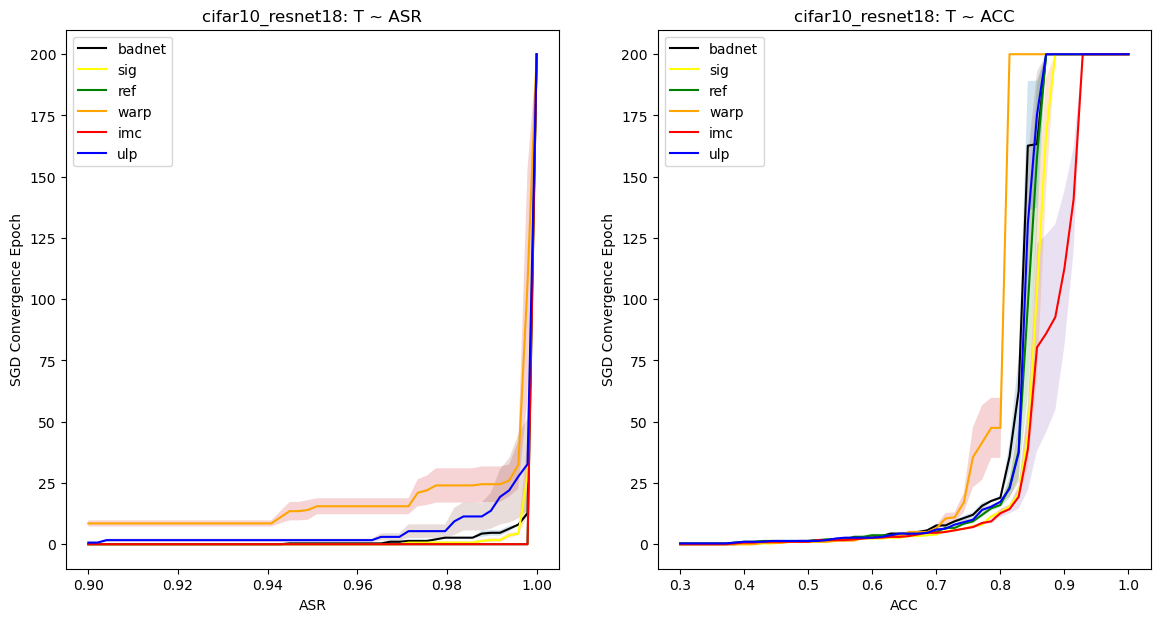

In [105]:
fig = plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for k in method_list:
    asr_axis  = list(map(np.mean, zip(*[res_dict_plot[k][seed]['asr'] for seed in res_dict_plot[k]])))
    tasr_axis = list(map(np.mean, zip(*[res_dict_plot[k][seed]['t_asr'] for seed in res_dict_plot[k]])))
    tasr_bar  = list(map(np.std,  zip(*[res_dict_plot[k][seed]['t_asr'] for seed in res_dict_plot[k]])))
    
    plt.plot(np.array(asr_axis), np.array(tasr_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(asr_axis), np.array(tasr_axis)-np.array(tasr_bar)/2, np.array(tasr_axis)+np.array(tasr_bar)/2, 
                     alpha=0.2)

plt.xlabel('ASR')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ASR")

plt.subplot(1, 2, 2)
for k in method_list:
    acc_axis  = list(map(np.mean, zip(*[res_dict_plot[k][seed]['acc'] for seed in res_dict_plot[k]])))
    tacc_axis = list(map(np.mean, zip(*[res_dict_plot[k][seed]['t_acc'] for seed in res_dict_plot[k]])))
    tacc_bar  = list(map(np.std, zip(*[res_dict_plot[k][seed]['t_acc'] for seed in res_dict_plot[k]])))
    
    plt.plot(np.array(acc_axis), np.array(tacc_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(acc_axis), np.array(tacc_axis)-np.array(tacc_bar)/2, np.array(tacc_axis)+np.array(tacc_bar)/2, 
                     alpha=0.2)

plt.xlabel('ACC')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ACC")

plt.show()

### With Cliping and DataAug, No AdvTrain

In [106]:
agg_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (~res_dict['use_advtrain']))]
agg_dict = agg_dict[['dataset', 'network', 'method', 'acc', 'asr', 't']].groupby(by=['dataset', 'network', 'method']).agg(func=['mean', 'std'])
agg_dict['ACC'] = agg_dict['acc']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['acc']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['ASR'] = agg_dict['asr']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['asr']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['T'] =agg_dict['t']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['t']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict[['ACC', 'ASR', 'T']].columns = ['ACC', 'ASR', 'T']
agg_dict[['ACC', 'ASR', 'T']].loc[['cifar10', 'gtsrb'], ['resnet18', 'vgg16'], ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp'], :]

/tmp/ipykernel_8762/3532739324.py:7: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  agg_dict[['ACC', 'ASR', 'T']].loc[['cifar10', 'gtsrb'], ['resnet18', 'vgg16'], ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp'], :]


ACC                ASR  \
                                                                
dataset network  method                                         
cifar10 resnet18 badnet  0.939 $\pm$ 0.000  0.999 $\pm$ 0.000   
                 sig     0.942 $\pm$ 0.002  0.998 $\pm$ 0.002   
                 ref     0.937 $\pm$ 0.004  0.999 $\pm$ 0.000   
                 warp    0.938 $\pm$ 0.002  1.000 $\pm$ 0.000   
                 ulp     0.941 $\pm$ 0.002  0.998 $\pm$ 0.003   
        vgg16    badnet  0.933 $\pm$ 0.001  0.999 $\pm$ 0.000   
                 sig     0.934 $\pm$ 0.000  0.997 $\pm$ 0.002   
                 ref     0.934 $\pm$ 0.001  0.999 $\pm$ 0.000   
                 warp    0.925 $\pm$ 0.003  1.000 $\pm$ 0.000   
                 ulp     0.933 $\pm$ 0.002  0.992 $\pm$ 0.007   
gtsrb   resnet18 badnet  0.944 $\pm$ 0.002  0.984 $\pm$ 0.000   
                 sig     0.940 $\pm$ 0.001  0.984 $\pm$ 0.000   
                 ref     0.943 $\pm$ 0.012  0.984 $\pm$ 0.000   
                 warp    0.928 $\pm$ 0.008  0.827 $\pm$ 0.289   
                 ulp     0.945 $\pm$ 0.004  0.984 $\pm$ 0.000   
        vgg16    badnet  0.954 $\pm$ 0.000  0.984 $\pm$ 0.000   
                 sig     0.958 $\pm$ 0.001  0.984 $\pm$ 0.000   
                 ref     0.962 $\pm$ 0.002  0.984 $\pm$ 0.000   
                 warp    0.956 $\pm$ 0.004  0.997 $\pm$ 0.001   
                 ulp     0.948 $\pm$ 0.003  0.984 $\pm$ 0.000   

                                            T  
                                               
dataset network  method                        
cifar10 resnet18 badnet     8.667 $\pm$ 1.155  
                 sig        8.667 $\pm$ 1.528  
                 ref        9.333 $\pm$ 1.528  
                 warp      12.667 $\pm$ 1.528  
                 ulp        6.571 $\pm$ 1.134  
        vgg16    badnet     4.667 $\pm$ 0.577  
                 sig        5.000 $\pm$ 1.732  
                 ref        4.667 $\pm$ 0.577  
                 warp       8.000 $\pm$ 0.000  
                 ulp        5.000 $\pm$ 2.000  
gtsrb   resnet18 badnet     5.667 $\pm$ 1.155  
                 sig        4.667 $\pm$ 0.577  
                 ref        5.000 $\pm$ 3.464  
                 warp    81.333 $\pm$ 102.768  
                 ulp     69.667 $\pm$ 112.882  
        vgg16    badnet     3.000 $\pm$ 1.000  
                 sig        2.667 $\pm$ 0.577  
                 ref        2.000 $\pm$ 0.000  
                 warp      20.000 $\pm$ 1.732  
                 ulp        4.000 $\pm$ 1.000

In [107]:
method_list  = ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp']
dataset = 'cifar10'
network = 'resnet18'

res_dict_plot = defaultdict(list)

for combo in product(method_list, [dataset], [network]):
    
    method, dataset, network = combo
    if method == 'uap':
        continue
        
    logfiles = list(filter(re.compile(f'({method}_{dataset}_{network})+.*').match, logs))
    
    res_dict_plot[method] = defaultdict(list)
    for logfile in logfiles:

        with open(os.path.join(logdir, logfile), 'rb') as f:
            config = pkl.load(f)
            result = pkl.load(f)
        f.close()
        
        n_epochs = config['train'][config['args']['dataset']]['N_EPOCHS']
        if (n_epochs < 80) or \
            (not config['train']['USE_CLIP']) or \
            (not config['train']['USE_TRANSFORM']) or \
            (config['adversarial']['ADV_TRAIN']) or \
            config['network']['PRETRAINED']:
                continue
        
        res_dict_plot[method][config['args']['seed']] = defaultdict(list)
        
        for asr_thresh in np.linspace(0.9, 1, 50):
            res_dict_plot[method][config['args']['seed']]['asr'].append(asr_thresh)
            cond = (np.array(result['test_troj_acc']) >= asr_thresh) & (np.array(result['test_clean_acc']) >= 0.0)
            res_dict_plot[method][config['args']['seed']]['t_asr'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)
            
        for acc_thresh in np.linspace(0.3, 1, 50):
            res_dict_plot[method][config['args']['seed']]['acc'].append(acc_thresh)
            cond = (np.array(result['test_troj_acc']) >= 0.0) & (np.array(result['test_clean_acc']) >= acc_thresh)
            res_dict_plot[method][config['args']['seed']]['t_acc'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)

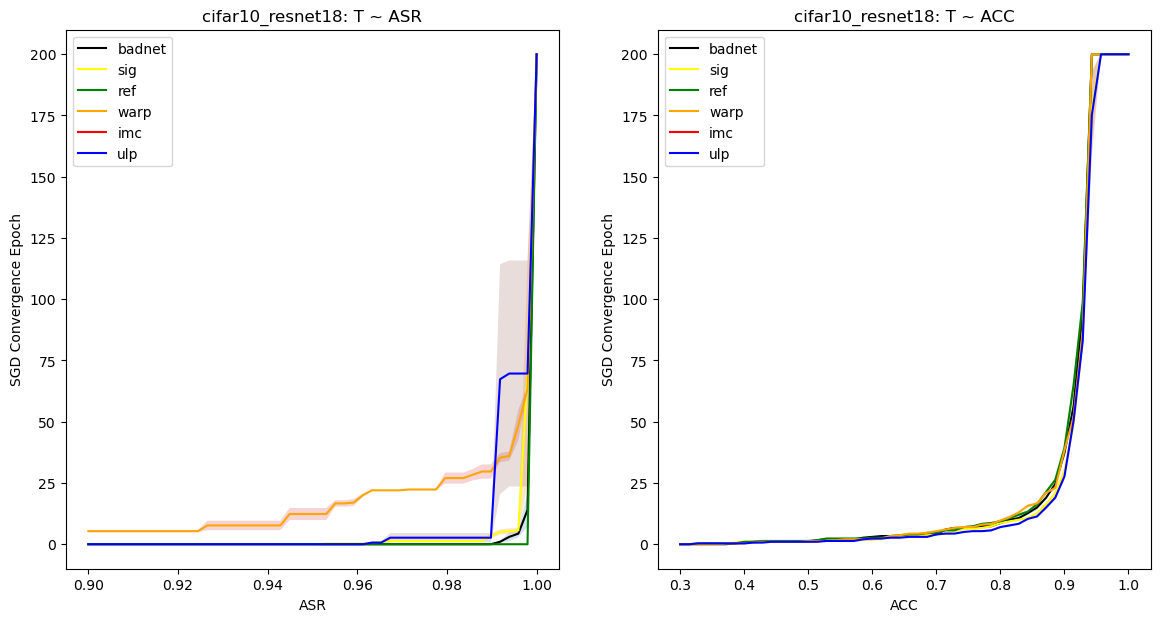

In [108]:
fig = plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for k in method_list:
    asr_axis  = list(map(np.mean, zip(*[res_dict_plot[k][seed]['asr'] for seed in res_dict_plot[k]])))
    tasr_axis = list(map(np.mean, zip(*[res_dict_plot[k][seed]['t_asr'] for seed in res_dict_plot[k]])))
    tasr_bar  = list(map(np.std,  zip(*[res_dict_plot[k][seed]['t_asr'] for seed in res_dict_plot[k]])))
    
    plt.plot(np.array(asr_axis), np.array(tasr_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(asr_axis), np.array(tasr_axis)-np.array(tasr_bar)/2, np.array(tasr_axis)+np.array(tasr_bar)/2, 
                     alpha=0.2)

plt.xlabel('ASR')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ASR")

plt.subplot(1, 2, 2)
for k in method_list:
    acc_axis  = list(map(np.mean, zip(*[res_dict_plot[k][seed]['acc'] for seed in res_dict_plot[k]])))
    tacc_axis = list(map(np.mean, zip(*[res_dict_plot[k][seed]['t_acc'] for seed in res_dict_plot[k]])))
    tacc_bar  = list(map(np.std, zip(*[res_dict_plot[k][seed]['t_acc'] for seed in res_dict_plot[k]])))
    
    plt.plot(np.array(acc_axis), np.array(tacc_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(acc_axis), np.array(tacc_axis)-np.array(tacc_bar)/2, np.array(tacc_axis)+np.array(tacc_bar)/2, 
                     alpha=0.2)

plt.xlabel('ACC')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ACC")

plt.show()

In [118]:
# write missing cmd to a tmp file

current_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (~res_dict['use_advtrain']))]
port_start   = 12315
gpu_start    = 2
gpu = gpu_start

cmd_list = []
for combo in product(method_list, dataset_list, network_list, seed_list):
    
    method, dataset, network, seed = combo
    
    cond1 = (current_dict['dataset']==dataset)
    cond2 = (current_dict['network']==network)
    cond3 = (current_dict['method']==method)
    cond4 = ((current_dict['seed']==f'{seed}') | (current_dict['seed']==seed))
    
    if len(current_dict.loc[cond1 & cond2 & cond3 & cond4])>0:
        continue
    
    if dataset == 'imagenet':
        continue
    
    if network == 'densenet121':
        continue
        
    if method != 'imc':
        continue
    
    cmd_list.append(f"CUDA_VISIBLE_DEVICES={gpu} torchrun --rdzv_endpoint=localhost:{port_start} --nnodes=1 --nproc_per_node=1 run_attack.py --dataset {dataset} --network {network} --method {method} --gpus {gpu} --seed {seed} &")
    
    port_start += 1
    gpu = (gpu+1)%8
    if gpu == 0:
        gpu = gpu_start
    
if len(cmd_list):
    with open('execute_missing_experiments.sh', 'w') as f:
        for cmd in cmd_list:
            f.write(cmd)
            f.write('\n')
        f.close()

In [119]:
cmd_list

['CUDA_VISIBLE_DEVICES=2 torchrun --rdzv_endpoint=localhost:12315 --nnodes=1 --nproc_per_node=1 run_attack.py --dataset cifar10 --network resnet18 --method imc --gpus 2 --seed 77 &',
 'CUDA_VISIBLE_DEVICES=3 torchrun --rdzv_endpoint=localhost:12316 --nnodes=1 --nproc_per_node=1 run_attack.py --dataset cifar10 --network resnet18 --method imc --gpus 3 --seed 78 &',
 'CUDA_VISIBLE_DEVICES=4 torchrun --rdzv_endpoint=localhost:12317 --nnodes=1 --nproc_per_node=1 run_attack.py --dataset cifar10 --network resnet18 --method imc --gpus 4 --seed 79 &',
 'CUDA_VISIBLE_DEVICES=5 torchrun --rdzv_endpoint=localhost:12318 --nnodes=1 --nproc_per_node=1 run_attack.py --dataset cifar10 --network vgg16 --method imc --gpus 5 --seed 77 &',
 'CUDA_VISIBLE_DEVICES=6 torchrun --rdzv_endpoint=localhost:12319 --nnodes=1 --nproc_per_node=1 run_attack.py --dataset cifar10 --network vgg16 --method imc --gpus 6 --seed 78 &',
 'CUDA_VISIBLE_DEVICES=7 torchrun --rdzv_endpoint=localhost:12320 --nnodes=1 --nproc_per_no

### With Cliping and DataAug, AdvTrain

In [111]:
agg_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (res_dict['use_advtrain']))]
agg_dict = agg_dict[['dataset', 'network', 'method', 'acc', 'asr', 't']].groupby(by=['dataset', 'network', 'method']).agg(func=['mean', 'std'])
agg_dict['ACC'] = agg_dict['acc']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['acc']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['ASR'] = agg_dict['asr']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['asr']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['T'] =agg_dict['t']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['t']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict[['ACC', 'ASR', 'T']].columns = ['ACC', 'ASR', 'T']
agg_dict[['ACC', 'ASR', 'T']].loc[['cifar10', 'gtsrb'], ['resnet18', 'vgg16'], ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp'], :]

/tmp/ipykernel_8762/335215312.py:7: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  agg_dict[['ACC', 'ASR', 'T']].loc[['cifar10', 'gtsrb'], ['resnet18', 'vgg16'], ['badnet', 'sig', 'ref', 'warp', 'imc', 'ulp'], :]


ACC                ASR  \
                                                                
dataset network  method                                         
cifar10 resnet18 badnet  0.899 $\pm$ 0.004  0.989 $\pm$ 0.003   
                 sig     0.903 $\pm$ 0.002  0.962 $\pm$ 0.008   
                 ref     0.887 $\pm$ 0.005  0.987 $\pm$ 0.008   
                 warp    0.882 $\pm$ 0.010  0.919 $\pm$ 0.050   
                 ulp     0.904 $\pm$ 0.004  0.989 $\pm$ 0.008   
        vgg16    badnet  0.897 $\pm$ 0.002  0.991 $\pm$ 0.001   
                 sig     0.900 $\pm$ 0.001  0.947 $\pm$ 0.011   
                 ref     0.901 $\pm$ 0.001  0.989 $\pm$ 0.005   
                 warp    0.882 $\pm$ 0.008  0.958 $\pm$ 0.010   
                 ulp     0.898 $\pm$ 0.003  0.844 $\pm$ 0.023   
gtsrb   resnet18 badnet  0.907 $\pm$ 0.007  0.971 $\pm$ 0.002   
                 sig     0.915 $\pm$ 0.007  0.913 $\pm$ 0.065   
                 ref     0.900 $\pm$ 0.004  0.979 $\pm$ 0.000   
                 warp    0.892 $\pm$ 0.009  0.899 $\pm$ 0.004   
                 ulp     0.911 $\pm$ 0.012  0.962 $\pm$ 0.022   
        vgg16    badnet  0.939 $\pm$ 0.003  0.971 $\pm$ 0.006   
                 sig     0.944 $\pm$ 0.002  0.940 $\pm$ 0.063   
                 ref     0.948 $\pm$ 0.005  0.979 $\pm$ 0.000   
                 warp    0.932 $\pm$ 0.003  0.876 $\pm$ 0.067   
                 ulp     0.941 $\pm$ 0.006  0.954 $\pm$ 0.040   

                                            T  
                                               
dataset network  method                        
cifar10 resnet18 badnet    42.000 $\pm$ 5.292  
                 sig       36.000 $\pm$ 2.646  
                 ref       52.333 $\pm$ 6.429  
                 warp    135.667 $\pm$ 55.824  
                 ulp       37.357 $\pm$ 4.217  
        vgg16    badnet    32.333 $\pm$ 1.528  
                 sig       29.000 $\pm$ 0.000  
                 ref       25.333 $\pm$ 0.577  
                 warp      71.667 $\pm$ 4.726  
                 ulp      200.000 $\pm$ 0.000  
gtsrb   resnet18 badnet  143.667 $\pm$ 51.003  
                 sig     175.667 $\pm$ 42.147  
                 ref     185.000 $\pm$ 25.981  
                 warp     200.000 $\pm$ 0.000  
                 ulp     163.667 $\pm$ 62.931  
        vgg16    badnet   79.667 $\pm$ 32.254  
                 sig      99.333 $\pm$ 87.186  
                 ref       33.000 $\pm$ 6.245  
                 warp     200.000 $\pm$ 0.000  
                 ulp      93.333 $\pm$ 92.511

In [112]:
# write missing cmd to a tmp file

current_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (res_dict['use_advtrain']))]
port_start   = 12315
gpu_start    = 5
gpu = gpu_start

cmd_list = []
for combo in product(method_list, dataset_list, network_list, seed_list):
    
    method, dataset, network, seed = combo
    
    cond1 = (current_dict['dataset']==dataset)
    cond2 = (current_dict['network']==network)
    cond3 = (current_dict['method']==method)
    cond4 = ((current_dict['seed']==f'{seed}') | (current_dict['seed']==seed))
    
    if len(current_dict.loc[cond1 & cond2 & cond3 & cond4])>0:
        continue
    
    if dataset == 'imagenet':
        continue
    
    if network == 'densenet121':
        continue
        
    if method != 'ulp':
        continue
    
    cmd_list.append(f"CUDA_VISIBLE_DEVICES={gpu} torchrun --rdzv_endpoint=localhost:{port_start} --nnodes=1 --nproc_per_node=1 run_attack.py --dataset {dataset} --network {network} --method {method} --gpus {gpu} --seed {seed} &")
    
    port_start += 1
    gpu = (gpu+1)%8
    if gpu == 0:
        gpu = gpu_start
    
if len(cmd_list):
    with open('execute_missing_experiments.sh', 'w') as f:
        for cmd in cmd_list:
            f.write(cmd)
            f.write('\n')
        f.close()

In [113]:
cmd_list

[]